# Table of Contents
* [1. Abstract](#1.-Abstract)
* [2. Introduction](#2.-Introduction)
	* [2.1 Checklist](#2.1-Checklist)
* [3. Experimental and computational details](#3.-Experimental-and-computational-details)
	* [3.1 Parameters](#3.1-Parameters)
	* [3.2 Initialize analysis framework](#3.2-Initialize-analysis-framework)
* [4. Experimental analysis](#4.-Experimental-analysis)
	* [4.1 Import experimental spectra](#4.1-Import-experimental-spectra)
		* [4.1.1 Import data files and organize](#4.1.1-Import-data-files-and-organize)
		* [4.1.2 Plot a sample spectrum to make sure import worked](#4.1.2-Plot-a-sample-spectrum-to-make-sure-import-worked)
	* [4.2 Resonance peak wavelength determination](#4.2-Resonance-peak-wavelength-determination)
		* [4.2.1 Peak fitting analysis code](#4.2.1-Peak-fitting-analysis-code)
		* [4.2.2 Plot of LSPR peak wavelength position vs tempearture](#4.2.2-Plot-of-LSPR-peak-wavelength-position-vs-tempearture)
		* [4.2.3 Plot of LSPR peak wavelength shift vs temperature](#4.2.3-Plot-of-LSPR-peak-wavelength-shift-vs-temperature)
		* [4.2.4 Plots of hydrodynamic radius and relative hydrodynamics vs temperature](#4.2.4-Plots-of-hydrodynamic-radius-and-relative-hydrodynamics-vs-temperature)
		* [4.2.5 Plot of LSPR peak wavelength vs hydrodynamic radius](#4.2.5-Plot-of-LSPR-peak-wavelength-vs-hydrodynamic-radius)
		* [4.2.6 Plots of LSPR peak shift vs relative hydrodynamic radius](#4.2.6-Plots-of-LSPR-peak-shift-vs-relative-hydrodynamic-radius)
	* [4.3 Mie theory for peak LSPR of Au NP in homogeneous medium](#4.3-Mie-theory-for-peak-LSPR-of-Au-NP-in-homogeneous-medium)


The influence of shell structure on plasmonic resonances in core-shell metal-polymer nanoparticles 
=================================

# 1. Abstract

Plasmonic nanoparticles can be encapsulated in polymer shells with the capability for externally triggered swelling and collapse behaviors. This behavior can cause a shift in the LSPR peak wavelength due to changes in the scattering contribution and the NP near-field refractive index. It has been predicted that the increase in refractive index due to collapse will influence the resonance more than the change in scattering, resulting in a net red shift of the resonance peak position. Here we demonstrate this rule experimentally, while also showing that the structure and thickness of the shell play critical roles in the magnitude of the peak wavelength shift. 

# 2. Introduction

## 2.1 Checklist

- Determine peak position of spectra.
- Determine the near-field refractive index (NFRI) from a homogeneous medium fit (no shell).
  - Use the NFRI to determine the polymer grafting density.

# 3. Experimental and computational details

## 3.1 Parameters

- Synthesis protocols and structural analysis available in previous works
- Spherical cores and shells
- Core diameters $d_{\text{core}}=$ 18? nm
- Shell diameters $d_{\text{shell}}=$ 20-60 nm
- Au cores, with refractive index (RI) $n_{\text{Au}}$ from J&C 1972
- Relevant LSPR peak wavelengths $\lambda=$ 500-550 nm

## 3.2 Initialize analysis framework

In [1]:
%run "header.py"

Loading import modules ...
Loading analysis codes ... 
  ... refractive index functions loaded:
       Au, Ag, SiO2, ITO, ZnO, H2O, 
       ethanol, CS2, benzene, toluene, 
       chloroform, methanol, butanol, 
       propanol
  ... Mie functions loaded
  ... local Mie functions loaded
Ready player one.


In [2]:
%run "header_parallel.py"

Initializing cluster ...
   Client variable 'kernels'
   Cluster Direct View variable 'cluster'
   Variable 'nKernels' = 2
importing mie on engine(s)
importing mie_local on engine(s)


# 4. Experimental analysis

## 4.1 Import experimental spectra

### 4.1.1 Import data files and organize

In [246]:
print("Import and organize data")
print("========================")
folderName = 'data_20160905'
fileNames = []
print("Importing data in folder",folderName,"...")
for file in os.listdir(folderName):
    #if file.endswith('.dat'): 
        fileNames.append(file)
spectraNames = []
spectraTemps = []
def importData(fileName):
    print("  *",fileName)
    headerLines = 0
    if (fileName == 'Au-linPNIPAM-long-hydr-radius.dat'
        or fileName == 'Au-linPNIPAM-medium-hydr-radius.dat'
        or fileName == 'Au-linPNIPAM-short-hydr-radius.dat'): 
        headerLines = 3
    elif (fileName == 'Au-linPNIPAM-long.dat'
          or fileName == 'Au-linPNIPAM-medium.dat'
          or fileName == 'Au-linPNIPAM-short.dat'): 
        headerLines = 2
        columnNames = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', dtype=str, comments='\\', skip_header=0, max_rows=1)[1:-1]
        spectraNames.append(columnNames.tolist())
        temps = []
        for name in columnNames:
            temps.append(float(name[-5:-3]))
        spectraTemps.append(temps)
        #print(columnNames)
    else: headerLines = 2
    tempData = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', skip_header=headerLines)
    return tempData
data = list(map(importData,fileNames))

# Last column indicates sample shell thickness:
# 0 = long (thick)
# 1 = medium
# 2 = short (thin)
print("Oganizing data ...")
dataList = []
for i in range(3):
    dlsData = data[2*i]
    spectraData0 = data[2*i+1]
    temps = spectraTemps[i]
    hydroRs = []
    for T in temps:
        sortByT = np.abs(dlsData[:,0] - T) < 3
        subset = dlsData[sortByT]
        if len(subset) == 0:
            sortByT = np.abs(dlsData[:,1] - T) < 5
            subset = dlsData[sortByT]
        rh = np.mean(subset[:,1])
        hydroRs.append(rh)
    for ii in range(len(temps)):
        for iii in range(len(spectraData0)):
            dataPoint = [ spectraData0[iii,0], spectraData0[iii,ii+1], temps[ii], hydroRs[ii].tolist(), i ]
            dataList.append(dataPoint)
dataArray = np.asarray(dataList)
print("  * extrapolate hydrodynamic radius from DLS to UV-Vis temps")
print("  * organized as [ wl-nm, abs, temp, Rh, sample-# ]")
print("  * sample 0 = thick shell, 1 = medium, 2 = thin")

# Au cores only
spectrumCore = data[-1]
print("  * core alone sorted separately")

print("Done.")

Import and organize data
Importing data in folder data_20160905 ...
  * Au-linPNIPAM-long-hydr-radius.dat
  * Au-linPNIPAM-long.dat
  * Au-linPNIPAM-medium-hydr-radius.dat
  * Au-linPNIPAM-medium.dat
  * Au-linPNIPAM-short-hydr-radius.dat
  * Au-linPNIPAM-short.dat
  * AW5.txt
Oganizing data ...
  * extrapolate hydrodynamic radius from DLS to UV-Vis temps
  * organized as [ wl-nm, abs, temp, Rh, sample-# ]
  * sample 0 = thick shell, 1 = medium, 2 = thin
  * core alone sorted separately
Done.


### 4.1.2 Plot a sample spectrum to make sure import worked

Also plot a zoomed in spectrum to look at noise.

Sample spectrum
Exported to:
 graphics_sample-spectrum_20160906.svg


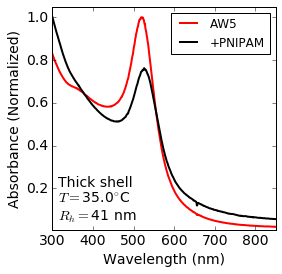

In [247]:
print('Sample spectrum')
print('===============')
def plotAndSave ():   
    ## Input data
    sampleNum = 0
    temp = spectraTemps[sampleNum][7]
    wlMin, wlMax = 300, 850
    
    sortByShell = dataArray[:,-1] == sampleNum
    plotArray = dataArray[sortByShell]
    sortByTemp = plotArray[:,-3] == temp
    plotArray = plotArray[sortByTemp]
    wlRange = plotArray[:,0] >= wlMin
    plotArray = plotArray[wlRange]
    wlRange = plotArray[:,0] <= wlMax
    plotArray = plotArray[wlRange]
    x, y = plotArray[:,0], plotArray[:,1]
    y = y/np.amax(y)
    xCore, yCore = spectrumCore[100:,0], spectrumCore[100:,1]
    yCore = yCore*np.amax(y)/np.amax(yCore)
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)-np.amax(y)*.05, np.amax(y)*1.05]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(xCore, yCore, color='red', linewidth=2, label="AW5")
    pylab.plot(x, y, color='black', linewidth=2, label="+PNIPAM")
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Absorbance (Normalized)")
    figText = (['Thick','Med.','Thin'][sampleNum]+' shell'+'\n'
        +'$T=$'+str(temp)+'$^{\circ}$C'+'\n'
        + '$R_h=$'+str(int(plotArray[0][-2]))+' nm')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    pylab.legend(loc='upper right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"sample-spectrum_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


Sample spectrum
Exported to:
 graphics_sample-spectrum-zoom_20160906.svg


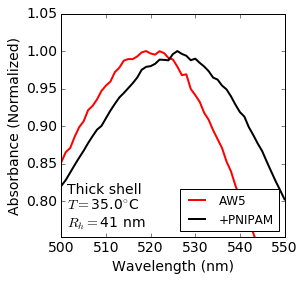

In [248]:
print('Sample spectrum')
print('===============')
def plotAndSave ():   
    ## Input data
    sampleNum = 0
    temp = spectraTemps[sampleNum][7]
    wlMin, wlMax = 500, 550
    
    sortByShell = dataArray[:,-1] == sampleNum
    plotArray = dataArray[sortByShell]
    sortByTemp = plotArray[:,-3] == temp
    plotArray = plotArray[sortByTemp]
    wlRange = plotArray[:,0] >= wlMin
    plotArray = plotArray[wlRange]
    wlRange = plotArray[:,0] <= wlMax
    plotArray = plotArray[wlRange]
    x, y = plotArray[:,0], plotArray[:,1]
    y = y/np.amax(y)
    xCore, yCore = spectrumCore[100:,0], spectrumCore[100:,1]
    yCore = yCore*np.amax(y)/np.amax(yCore)
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)-np.amax(y)*.05, np.amax(y)*1.05]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(xCore, yCore, color='red', linewidth=2, label="AW5")
    pylab.plot(x, y, color='black', linewidth=2, label="+PNIPAM")
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Absorbance (Normalized)")
    figText = (['Thick','Med.','Thin'][sampleNum]+' shell'+'\n'
        +'$T=$'+str(temp)+'$^{\circ}$C'+'\n'
        + '$R_h=$'+str(int(plotArray[0][-2]))+' nm')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"sample-spectrum-zoom_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


## 4.2 Resonance peak wavelength determination

### 4.2.1 Peak fitting analysis code

In [249]:
print("LSPR analysis")
print("=============")
print("Peak detection")
threshold = 0.25
wlMinnm, wlMaxnm = 400, 600

# Core only
wlPeakCorenm = 0
wlRange = spectrumCore[:,0] >= wlMinnm
dataSubArray = spectrumCore[wlRange]
wlRange = spectrumCore[:,0] <= wlMaxnm
dataSubArray = spectrumCore[wlRange]
if dataSubArray.size > 0:
    x, y = dataSubArray[:,0], dataSubArray[:,1]
    base = peakutils.baseline(y,2)
    yCorr = y - 0*base
    indexes = peakutils.indexes(y, thres=threshold, min_dist=10)
    indexesCorr = peakutils.indexes(yCorr, thres=threshold, min_dist=10)
    if indexesCorr.size > 0: 
        if indexesCorr.size > 1: indexesCorr = [indexesCorr[-1]]
        wlPeaknm = peakutils.interpolate(x, yCorr, ind=indexesCorr)
        wlPeakCorenm = wlPeaknm[0]
        print("Bare core LSPR peak at", format(wlPeakCorenm,'.1f'), " nm")

# Shell
lsprPeakList = []
for sampleNum in range(3):
    for tempC in spectraTemps[sampleNum]:
        sortByShell = dataArray[:,-1] == sampleNum
        dataSubArray = dataArray[sortByShell]
        sortByTemp = dataSubArray[:,-3] == tempC
        dataSubArray = dataSubArray[sortByTemp]
        wlRange = dataSubArray[:,0] >= wlMinnm
        dataSubArray = dataSubArray[wlRange]
        wlRange = dataSubArray[:,0] <= wlMaxnm
        dataSubArray = dataSubArray[wlRange]
        Rh = dataSubArray[0][-2]
        if dataSubArray.size > 0:
            x, y = dataSubArray[:,0], dataSubArray[:,1]
            base = peakutils.baseline(y,2)
            yCorr = y - 0*base
            indexes = peakutils.indexes(y, thres=threshold, min_dist=10)
            indexesCorr = peakutils.indexes(yCorr, thres=threshold, min_dist=10)
            if indexesCorr.size > 0: 
                if indexesCorr.size > 1: indexesCorr = [indexesCorr[-1]]
                wlPeaknm = peakutils.interpolate(x, yCorr, ind=indexesCorr)
                lsprPeakList.append([wlPeaknm[0], tempC, Rh, sampleNum])
lsprPeakArray = np.asarray(lsprPeakList)
print("Shell peaks")
print("  * format: [ wl-nm, temp-C, Rh-nm, sample-# ]")
print("  * min LSPR peak at",format(np.amin(lsprPeakArray[:,0]),'.1f'),"nm")
print("  * max LSPR peak at",format(np.amax(lsprPeakArray[:,0]),'.1f'),"nm")

LSPR analysis
Peak detection
Bare core LSPR peak at 519.7  nm
Shell peaks
  * format: [ wl-nm, temp-C, Rh-nm, sample-# ]
  * min LSPR peak at 523.4 nm
  * max LSPR peak at 526.3 nm


### 4.2.2 Plot of LSPR peak wavelength position vs tempearture

LSPR peak wavelength vs temperature
Exported to:
 graphics_wl-LSPR-vs-temp_20160906.svg


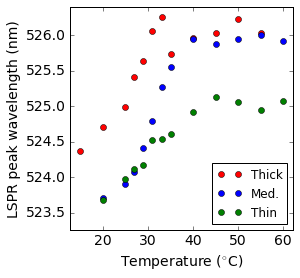

In [250]:
print('LSPR peak wavelength vs temperature')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,0:2]
    x, y = plotArray[:,1], plotArray[:,0]
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'o', color='blue', label="Med.")
    pylab.plot(x3, y3, 'o', color='green', label="Thin")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.ylabel("LSPR peak wavelength (nm)")
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"wl-LSPR-vs-temp_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


Interpretation
- The offset between the thick and medium shell curves at low temperatures shows that there is more polymer near the core. 
- The plateau in the thick shell curve at high temperatures is (probably) due to increased scattering. This limits the maximum LSPR shift.
- The thin and medium shell curves are the same at low temperatures, so they have similar amounts of polymer near the core.
- The difference between the thin and medium shell curves at high temperatures shows that the collapse of the thin shell brings it inside the near-field zone. Thus, the LSPR is influenced by the pure solvent too at high temperatures with a thin shell, limiting the maximum LSPR shift.

### 4.2.3 Plot of LSPR peak wavelength shift vs temperature

LSPR peak wavelength vs temperature
Exported to:
 graphics_dwl-LSPR-vs-temp_20160906.svg


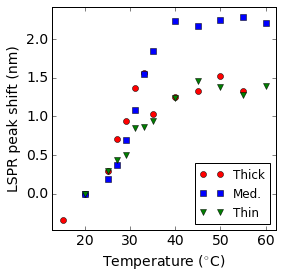

In [251]:
print('LSPR peak wavelength vs temperature')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,0:2]
    x, y = plotArray[:,1], plotArray[:,0]
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    y1, y2, y3 = y1-y1[1], y2-y2[0], y3-y3[0] # at 20C
    y = np.concatenate((y1, y2, y3))
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 's', color='blue', label="Med.")
    pylab.plot(x3, y3, 'v', color='green', label="Thin")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.ylabel("LSPR peak shift (nm)")
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"dwl-LSPR-vs-temp_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


### 4.2.4 Plots of hydrodynamic radius and relative hydrodynamics vs temperature

This DLS data is interpolated to determine the hydrodynamic radius of the particles at the temperatures at which the spectra are taken.

Temperature vs hydrodynamic radius
Exported to:
 graphics_Rh-vs-Temp_20160906.svg


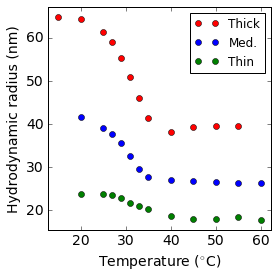

In [252]:
print('Temperature vs hydrodynamic radius')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,1:3]
    x, y = plotArray[:,0], plotArray[:,1]
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'o', color='blue', label="Med.")
    pylab.plot(x3, y3, 'o', color='green', label="Thin")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.ylabel("Hydrodynamic radius (nm)")
    pylab.legend(loc='upper right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"Rh-vs-Temp_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


Temperature vs hydrodynamic radius
Exported to:
 graphics_Rh-rel-vs-Temp_20160906.svg


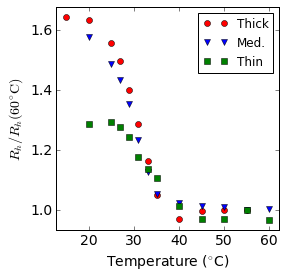

In [253]:
print('Temperature vs hydrodynamic radius')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,1:3]
    x, y = plotArray[:,0], plotArray[:,1]
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    y1, y2, y3 = y1/np.mean(y1[-2:-1]), y2/np.mean(y2[-2:-1]), y3/np.mean(y3[-2:-1])
    y = np.concatenate((y1,y2,y3))
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'v', color='blue', label="Med.")
    pylab.plot(x3, y3, 's', color='green', label="Thin")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.ylabel("$R_h/R_h(60^{\circ}\mathrm{C})$")
    pylab.legend(loc='upper right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"Rh-rel-vs-Temp_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


Temperature vs hydrodynamic radius
Exported to:
 graphics_Rh-rel-vs-Temp_20160906.svg


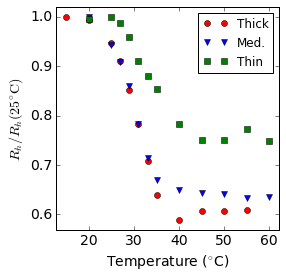

In [266]:
print('Temperature vs hydrodynamic radius')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,1:3]
    x, y = plotArray[:,0], plotArray[:,1]
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    y1, y2, y3 = y1/y1[0], y2/y2[0], y3/y3[1]
    y = np.concatenate((y1,y2,y3))
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'v', color='blue', label="Med.")
    pylab.plot(x3, y3, 's', color='green', label="Thin")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.ylabel("$R_h/R_h(25^{\circ}\mathrm{C})$")
    pylab.legend(loc='upper right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"Rh-rel-vs-Temp_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


### 4.2.5 Plot of LSPR peak wavelength vs hydrodynamic radius

LSPR peak wavelength vs hydrodynamic radius
Exported to:
 graphics_wl-LSPR-vs-Rh_20160906.svg


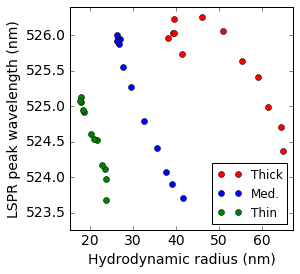

In [255]:
print('LSPR peak wavelength vs hydrodynamic radius')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,0:3:2]
    x, y = plotArray[:,1], plotArray[:,0]
    x0, y0 = [9.0], [wlPeakCorenm]
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'o', color='blue', label="Med.")
    pylab.plot(x3, y3, 'o', color='green', label="Thin")
    pylab.xlabel("Hydrodynamic radius (nm)")
    pylab.ylabel("LSPR peak wavelength (nm)")
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"wl-LSPR-vs-Rh_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


Expanded plot below shows LSPR peak from bare Au NP. Note that it is significantly different.

LSPR peak wavelength vs hydrodynamic radius
Exported to:
 graphics_wl-LSPR-vs-Rh_20160906.svg


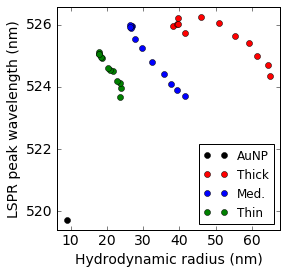

In [256]:
print('LSPR peak wavelength vs hydrodynamic radius')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,0:3:2]
    x, y = plotArray[:,1], plotArray[:,0]
    x0, y0 = [9.0], [wlPeakCorenm]
    xLimits = [np.amin(x), np.amax(x)]
    xLimits[0] = min([xLimits[0],x0[0]])
    yLimits = [np.amin(y), np.amax(y)]
    yLimits[0] = min([yLimits[0],y0[0]])
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    
    ## Specific format options
    pylab.plot(x0, y0, 'o', color='black', label="AuNP")
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'o', color='blue', label="Med.")
    pylab.plot(x3, y3, 'o', color='green', label="Thin")
    pylab.xlabel("Hydrodynamic radius (nm)")
    pylab.ylabel("LSPR peak wavelength (nm)")
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"wl-LSPR-vs-Rh_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


### 4.2.6 Plots of LSPR peak shift vs relative hydrodynamic radius

LSPR peak wavelength vs hydrodynamic radius


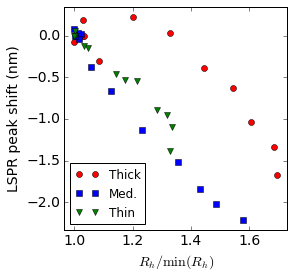

In [295]:
print('LSPR peak wavelength vs hydrodynamic radius')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,0:3:2]
    x, y = plotArray[:,1], plotArray[:,0]
    x0, y0 = [9.0], [wlPeakCorenm]
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    x1, x2, x3 = x1/min(x1), x2/min(x2), x3/min(x3)
    x = np.concatenate((x1,x2,x3))
    y1, y2, y3 = y1-y1[-1], y2-y2[-1], y3-y3[-1]
    y = np.concatenate((y1,y2,y3))
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 's', color='blue', label="Med.")
    pylab.plot(x3, y3, 'v', color='green', label="Thin")
    pylab.xlabel("$R_h/\mathrm{min}(R_h)$")
    pylab.ylabel("LSPR peak shift (nm)")
    pylab.legend(loc='lower left', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"dwl-LSPR-vs-Rh-rel_" + timestamp + exportFormat
    #pylab.savefig(filename, transparent=True)
    #print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


LSPR peak wavelength vs hydrodynamic radius
Exported to:
 graphics_dwl-LSPR-vs-Rh-rel_20160906.svg


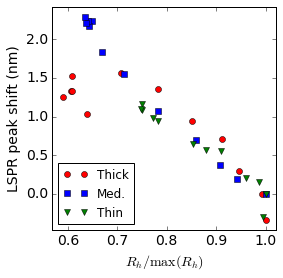

In [274]:
print('LSPR peak wavelength vs hydrodynamic radius')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,0:3:2]
    x, y = plotArray[:,1], plotArray[:,0]
    x0, y0 = [9.0], [wlPeakCorenm]
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    x1, x2, x3 = x1/max(x1), x2/max(x2), x3/max(x3)
    x = np.concatenate((x1,x2,x3))
    y1, y2, y3 = y1-y1[1], y2-y2[0], y3-y3[1]
    y = np.concatenate((y1,y2,y3))
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 's', color='blue', label="Med.")
    pylab.plot(x3, y3, 'v', color='green', label="Thin")
    pylab.xlabel("$R_h/\mathrm{max}(R_h)$")
    pylab.ylabel("LSPR peak shift (nm)")
    pylab.legend(loc='lower left', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"dwl-LSPR-vs-Rh-rel_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


LSPR peak wavelength vs hydrodynamic radius
Exported to:
 graphics_dwl-LSPR-vs-Rh-rel_20160906.svg


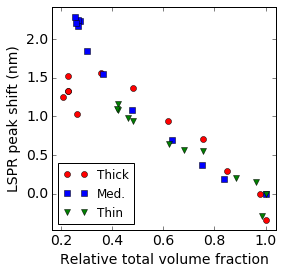

In [306]:
print('LSPR peak wavelength vs hydrodynamic radius')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,0:3:2]
    x, y = plotArray[:,1], plotArray[:,0]
    x0, y0 = [9.0], [wlPeakCorenm]
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    x1, x2, x3 = x1/max(x1), x2/max(x2), x3/max(x3)
    x1, x2, x3 = x1**3, x2**3, x3**3
    x = np.concatenate((x1,x2,x3))
    y1, y2, y3 = y1-y1[1], y2-y2[0], y3-y3[1]
    y = np.concatenate((y1,y2,y3))
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 's', color='blue', label="Med.")
    pylab.plot(x3, y3, 'v', color='green', label="Thin")
    pylab.xlabel("Relative total volume fraction")
    pylab.ylabel("LSPR peak shift (nm)")
    pylab.legend(loc='lower left', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"dwl-LSPR-vs-Rh-rel_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


LSPR peak wavelength vs hydrodynamic radius
using a core radius of 8.5 nm


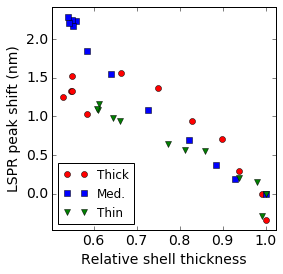

In [294]:
print('LSPR peak wavelength vs hydrodynamic radius')
print('===============')
print('using a core radius of 8.5 nm')
rCorenm = 8.5
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,0:3:2]
    x, y = plotArray[:,1], plotArray[:,0]
    x0, y0 = [9.0], [wlPeakCorenm]
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    x1, x2, x3 = (x1-rCorenm)/(max(x1)-rCorenm), (x2-rCorenm)/(max(x2)-rCorenm), (x3-rCorenm)/(max(x3)-rCorenm)
    x = np.concatenate((x1,x2,x3))
    y1, y2, y3 = y1-y1[1], y2-y2[0], y3-y3[1]
    y = np.concatenate((y1,y2,y3))
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 's', color='blue', label="Med.")
    pylab.plot(x3, y3, 'v', color='green', label="Thin")
    pylab.xlabel("Relative shell thickness")
    pylab.ylabel("LSPR peak shift (nm)")
    pylab.legend(loc='lower left', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"dwl-LSPR-vs-Rh-rel_" + timestamp + exportFormat
    #pylab.savefig(filename, transparent=True)
    #print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


LSPR peak wavelength vs hydrodynamic radius
using a core radius of 8.5 nm


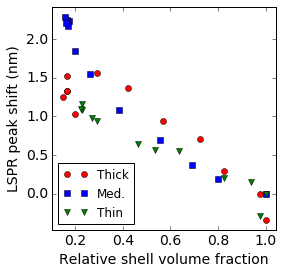

In [287]:
print('LSPR peak wavelength vs hydrodynamic radius')
print('===============')
print('using a core radius of 8.5 nm')
rCorenm = 8.5
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,0:3:2]
    x, y = plotArray[:,1], plotArray[:,0]
    x0, y0 = [9.0], [wlPeakCorenm]
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    x1, x2, x3 = (x1-rCorenm)/(max(x1)-rCorenm), (x2-rCorenm)/(max(x2)-rCorenm), (x3-rCorenm)/(max(x3)-rCorenm)
    x1, x2, x3 = x1**3, x2**3, x3**3
    x = np.concatenate((x1,x2,x3))
    y1, y2, y3 = y1-y1[1], y2-y2[0], y3-y3[1]
    y = np.concatenate((y1,y2,y3))
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 's', color='blue', label="Med.")
    pylab.plot(x3, y3, 'v', color='green', label="Thin")
    pylab.xlabel("Relative shell volume fraction")
    pylab.ylabel("LSPR peak shift (nm)")
    pylab.legend(loc='lower left', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"dwl-LSPR-vs-Rh-rel_" + timestamp + exportFormat
    #pylab.savefig(filename, transparent=True)
    #print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


## 4.3 Mie theory for peak LSPR of Au NP in homogeneous medium

Medium has refractive index $n_{\mathrm{med}}$.

In [296]:
print("Set parameter limits for computation")
print("====================================")

# parameter limits
rCorenm = 8.5
nmedMin, nmedMax, dnmed = 1.3, 1.555, 0.01
wl0Minnm, wl0Maxnm, dwl0nm = 450, 600, 1.5
lmax = 2

# check for lmax convergence
lmaxConvergeTable = []
startSec = time.time()
for nmed in [nmedMin, nmedMax]:
    result = mie_local.CextRelDipEMList(mie_local.CextEMListAu(lmax, rCorenm, nmed, wl0Minnm))
    lmaxConvergeTable.append(result[0])
    lmaxConvergeTable.append(result[1])
endSec = time.time()
print("Highest pole =",lmax,", max est. err. = ", format(100*max(lmaxConvergeTable), '.3f'),"%")
dtSec = endSec - startSec
cpuTimeSec = dtSec/2

nmedList = np.arange(nmedMin, nmedMax, dnmed)
nmedMax = np.amax(nmedList)
wl0Listnm = np.arange(wl0Minnm, wl0Maxnm, dwl0nm)
wl0Maxnm = np.amax(wl0Listnm)
print("Actual parameter ranges:")
print("  core radius:",rCorenm,"nm")
print("  refractive index:",[nmedMin, nmedMax],"x",dnmed)
print("  vacuum wavelength (nm):",[wl0Minnm, wl0Maxnm],"x",dwl0nm)

# contruct parameter list
paramList = []
for nmed in nmedList:
    for wl0nm in wl0Listnm:
        paramList.append([nmed, wl0nm])
paramArray = np.asarray(paramList)
Nsims = paramArray.shape[0]
print("Number of simulation instances = ", Nsims)
nProcs = nKernels
if nProcs == 0: nProcs = 1
print("  running on",nProcs,"processors")
print("  estimated",format(cpuTimeSec*1e3, '.3f'),"ms per instance")
print("Estimated run time = ",format(cpuTimeSec*Nsims/nProcs, '.3f'),"sec")

Set parameter limits for computation
Highest pole = 2 , max est. err. =  0.091 %
Actual parameter ranges:
  core radius: 8.5 nm
  refractive index: [1.3, 1.5500000000000003] x 0.01
  vacuum wavelength (nm): [450, 598.5] x 1.5
Number of simulation instances =  2600
  running on 2 processors
  estimated 0.000 ms per instance
Estimated run time =  0.000 sec


In [297]:
# Compute extinction cross section
print("Compute extinction spectra, parallel kernels")
print("============================================")
# return: vacuum wavelength (nm), 
#         refractive index, 
#         total scattering efficiency
#         total absorption efficiency
#         total extinction efficiency
def calcAtom(params):
    [nmed, wl0nm] = params
    [Cext,Cabs,Csca] = mie_local.CExtAbsScaAu(lmax, rCorenm, nmed, wl0nm)
    return [wl0nm, nmed, Cext,Cabs,Csca]

# distribute atom definition to parallel kernels
cluster.push(dict(
        lmax = lmax,
        rCorenm = rCorenm,
        calcAtom = calcAtom
    ))

# Loop over parameters
print("Computing ... ", end="")
startSec = time.time()
spectraAuLSPRList = list(cluster.map_sync(calcAtom, paramArray))
endSec = time.time()
print("done")
dtSec = endSec - startSec
spectraAuLSPRArray = np.asarray(spectraAuLSPRList)
Ncalcs = spectraAuLSPRArray.shape[0]
print("Run time = ", format(dtSec, '.3f'),"sec")
print("Time per simulation instance = ", format(1000*dtSec*nProcs/Ncalcs, '.3f'),"ms")
print("Return format: [ wl-nm, nmed, CExt-nm2, CAbs-nm2, CSca-nm2 ]")

Compute extinction spectra, parallel kernels
Computing ... done
Run time =  0.547 sec
Time per simulation instance =  0.421 ms
Return format: [ wl-nm, nmed, CExt-nm2, CAbs-nm2, CSca-nm2 ]


Sample spectrum


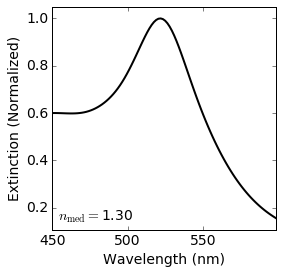

In [298]:
print('Sample spectrum')
print('===============')
def plotAndSave ():   
    ## Input data
    nmed = nmedList[0]
    
    sortBynmed = spectraAuLSPRArray[:,1] == nmed
    plotArray = spectraAuLSPRArray[sortBynmed]
    x, y = plotArray[:,0], plotArray[:,2]
    y = y/np.amax(y)
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)-np.amax(y)*.05, np.amax(y)*1.05]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(x, y, color='black', linewidth=2, label="+PNIPAM")
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Extinction (Normalized)")
    figText = ('$n_{\mathrm{med}}=$'+str(format(nmed,'.2f')))
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"sample-spectrum_" + timestamp + exportFormat
    #pylab.savefig(filename, transparent=True)
    #print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


In [299]:
print("LSPR analysis")
print("=============")
print("Peak detection")
threshold = 0.25

lsprMiePeakList = []
for nmed in nmedList:
    sortByRI = spectraAuLSPRArray[:,1] == nmed
    dataSubArray = spectraAuLSPRArray[sortByRI]
    if dataSubArray.size > 0:
        x, y = dataSubArray[:,0], dataSubArray[:,2]
        base = peakutils.baseline(y,2)
        yCorr = y - base
        indexes = peakutils.indexes(y, thres=threshold, min_dist=10)
        indexesCorr = peakutils.indexes(yCorr, thres=threshold, min_dist=10)
        if indexes.size > 0: 
            if indexes.size > 1: indexes = [indexes[-1]]
            wlPeaknm = peakutils.interpolate(x, y, ind=indexes)
            lsprMiePeakList.append([ nmed, wlPeaknm[0] ])
lsprMiePeakArray = np.asarray(lsprMiePeakList)
print("  * output array format: [ nmed, wl-nm ]")
print("  * LSPR peak min/max at (",format(np.amin(lsprMiePeakArray[:,1]),'.1f'),"nm,",format(np.amax(lsprMiePeakArray[:,1]),'.1f'),"nm )")

LSPR analysis
Peak detection
  * output array format: [ nmed, wl-nm ]
  * LSPR peak min/max at ( 521.3 nm, 536.7 nm )


LSPR Peak wavelength
Core radius = 8 nm
Exported to:
 graphics_lspr-wl-nm-vs-nmed_20160906.svg


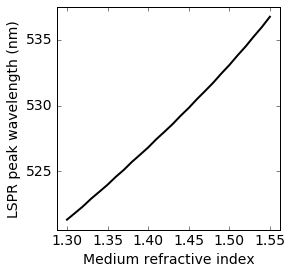

In [300]:
print('LSPR Peak wavelength')
print('====================')
print('Core radius =',str(int(rCorenm)),"nm")
def plotAndSave ():   
    ## Input data
    plotArray = lsprMiePeakArray
    x, y = plotArray[:,0], plotArray[:,1]
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(x, y, color='black', linewidth=2, label="LSPR")
    pylab.xlabel("Medium refractive index")
    pylab.ylabel("LSPR peak wavelength (nm)")
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-.05*dx, xLimits[1]+.05*dx)
    pylab.ylim(yLimits[0]-.05*dy, yLimits[1]+.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"lspr-wl-nm-vs-nmed_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


Near-field refractive index vs hydrodynamic radius
Exported to:
 graphics_wl-LSPR-vs-Rh_20160906.svg


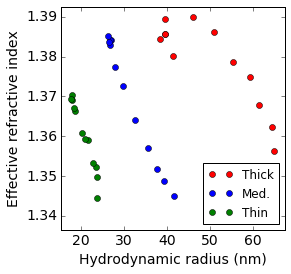

In [301]:
nmedOfMieLSPRnm = interpolate.interp1d(lsprMiePeakArray[:,1], lsprMiePeakArray[:,0], kind="cubic")
lsprPeaknmedArray = np.asarray(list(map(nmedOfMieLSPRnm, lsprPeakArray[:,0])))

print('Near-field refractive index vs hydrodynamic radius')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,0:3:2]
    x, y = plotArray[:,1], lsprPeaknmedArray
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'o', color='blue', label="Med.")
    pylab.plot(x3, y3, 'o', color='green', label="Thin")
    pylab.ylabel("Effective refractive index")
    pylab.xlabel("Hydrodynamic radius (nm)")
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"wl-LSPR-vs-Rh_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


Polymer volume fraction vs hydrodynamic radius
Estimated from effective/near-field refractive index
Refractive index converted to volume fraction using simple model from Arago and Biot
Using PNIPAM n = 1.51 , and water n = 1.3356706385047694
Exported to:
 graphics_vol-frac-vs-Rh_20160906.svg


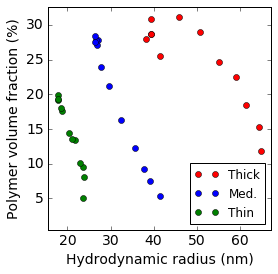

In [302]:
nmedOfMieLSPRnm = interpolate.interp1d(lsprMiePeakArray[:,1], lsprMiePeakArray[:,0], kind="cubic")
nPNIPAM = 1.51
nSolv = np.real(ri.nH2O(525))
lsprPeaknmedArray = np.asarray(list(map(nmedOfMieLSPRnm, lsprPeakArray[:,0])))
volFracArray = (lsprPeaknmedArray - nSolv)/(nPNIPAM-nSolv)

print('Polymer volume fraction vs hydrodynamic radius')
print('===============')
print('Estimated from effective/near-field refractive index')
print('Refractive index converted to volume fraction using simple model from Arago and Biot')
print('Using PNIPAM n =', nPNIPAM, ', and water n =', nSolv)
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray
    x, y = plotArray[:,2], 100*volFracArray
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'o', color='blue', label="Med.")
    pylab.plot(x3, y3, 'o', color='green', label="Thin")
    pylab.ylabel("Polymer volume fraction (%)")
    pylab.xlabel("Hydrodynamic radius (nm)")
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"vol-frac-vs-Rh_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


Grafting density vs hydrodynamic radius
Estimated from effective/near-field refractive index
At the surface the volume fraction = surface area fraction
Using PNIPAM n = 1.51 , and water n = 1.3356706385047694
Single polymer cross section = 0.19 nm^2
Exported to:
 graphics_vol-frac-vs-Rh_20160906.svg


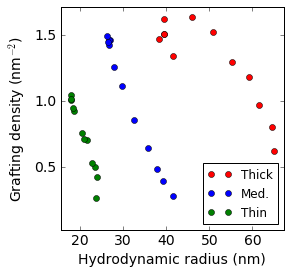

In [303]:
nmedOfMieLSPRnm = interpolate.interp1d(lsprMiePeakArray[:,1], lsprMiePeakArray[:,0], kind="cubic")
nPNIPAM = 1.51
nSolv = np.real(ri.nH2O(525))
lsprPeaknmedArray = np.asarray(list(map(nmedOfMieLSPRnm, lsprPeakArray[:,0])))
volFracArray = (lsprPeaknmedArray - nSolv)/(nPNIPAM-nSolv)
segVolnm3, segLnm = 0.095, 0.5 # Taken from Tagliazucchi et al 2012, http://dx.doi.org/10.1021/nn303221y
segAnm2 = segVolnm3/segLnm
graftingDensityArray = volFracArray/segAnm2

print('Grafting density vs hydrodynamic radius')
print('===============')
print('Estimated from effective/near-field refractive index')
print('At the surface the volume fraction = surface area fraction')
print('Using PNIPAM n =', nPNIPAM, ', and water n =', nSolv)
print('Single polymer cross section =',segAnm2,"nm^2")
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray
    x, y = plotArray[:,2], graftingDensityArray
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'o', color='blue', label="Med.")
    pylab.plot(x3, y3, 'o', color='green', label="Thin")
    pylab.ylabel("Grafting density (nm$^{-2}$)")
    pylab.xlabel("Hydrodynamic radius (nm)")
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"vol-frac-vs-Rh_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


Slightly more complicated model for the grafting density using the DLS shell thickness:  
Each polymer chain occupies the volume $v_p = A_p t$, where $A_p$ is the cross sectional area, estimated to be $A_p = 0.19 \mathrm{nm}^2$ (Tagliazucchi et al, 2012); and $t = R_h - R_{\mathrm{core}}$ is the shell thickness computed from the DLS data. Then the volume occupied by all polymer chains is $V_p = N A_p t$, where $N$ is the number of chains. The number of chains is related to the grafting density $\sigma$ by $N = \sigma\times 4\pi R_{\mathrm{core}}^2$. With a total shell volume $V_{\mathrm{shell}} = \frac43 \pi \left(R_h^3-R_{\mathrm{core}}^3\right)$, the grafting density can be computed from the volume fraction $\phi$ 
$$ \sigma = \phi \frac{\frac43\pi (R_h^3 - R_{\mathrm{core}}^3)}{A_p (R_h - R_{\mathrm{core}})\,4\pi R_{\mathrm{core}}^2}$$

Grafting density vs hydrodynamic radius
Estimated from effective/near-field refractive index
At the surface the volume fraction = surface area fraction
Using PNIPAM n = 1.51 , and water n = 1.3356706385047694
Single polymer cross section = 0.19 nm^2
Core radius = 8.5 nm
Exported to:
 graphics_vol-frac-vs-Rh_20160906.svg


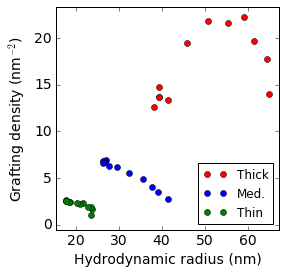

In [304]:
nmedOfMieLSPRnm = interpolate.interp1d(lsprMiePeakArray[:,1], lsprMiePeakArray[:,0], kind="cubic")
nPNIPAM = 1.51
nSolv = np.real(ri.nH2O(525))
lsprPeaknmedArray = np.asarray(list(map(nmedOfMieLSPRnm, lsprPeakArray[:,0])))
volFracArray = (lsprPeaknmedArray - nSolv)/(nPNIPAM-nSolv)
segVolnm3, segLnm = 0.095, 0.5 # Taken from Tagliazucchi et al 2012, http://dx.doi.org/10.1021/nn303221y
segAnm2 = segVolnm3/segLnm
RhnmArray = lsprPeakArray[:,2]
shellVolnm3Array = (4/3)*pi*(RhnmArray**3-rCorenm**3)
graftingDensityArray = volFracArray*shellVolnm3Array/(segAnm2*(RhnmArray-rCorenm)*4*pi*rCorenm**2)

print('Grafting density vs hydrodynamic radius')
print('===============')
print('Estimated from effective/near-field refractive index')
print('At the surface the volume fraction = surface area fraction')
print('Using PNIPAM n =', nPNIPAM, ', and water n =', nSolv)
print('Single polymer cross section =',segAnm2,"nm^2")
print('Core radius =',rCorenm,"nm")
def plotAndSave ():   
    ## Input data
    x, y = RhnmArray, graftingDensityArray
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'o', color='blue', label="Med.")
    pylab.plot(x3, y3, 'o', color='green', label="Thin")
    pylab.ylabel("Grafting density (nm$^{-2}$)")
    pylab.xlabel("Hydrodynamic radius (nm)")
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"vol-frac-vs-Rh_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


Grafting density vs hydrodynamic radius
Estimated from effective/near-field refractive index
At the surface the volume fraction = surface area fraction
Using PNIPAM n = 1.51 , and water n = 1.3356706385047694
Single polymer cross section = 0.19 nm^2
Core radius = 8.5 nm
Exported to:
 graphics_vol-frac-vs-Rh_20160906.svg


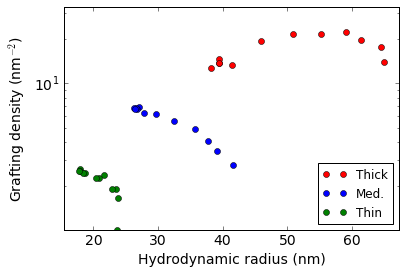

In [305]:
nmedOfMieLSPRnm = interpolate.interp1d(lsprMiePeakArray[:,1], lsprMiePeakArray[:,0], kind="cubic")
nPNIPAM = 1.51
nSolv = np.real(ri.nH2O(525))
lsprPeaknmedArray = np.asarray(list(map(nmedOfMieLSPRnm, lsprPeakArray[:,0])))
volFracArray = (lsprPeaknmedArray - nSolv)/(nPNIPAM-nSolv)
segVolnm3, segLnm = 0.095, 0.5 # Taken from Tagliazucchi et al 2012, http://dx.doi.org/10.1021/nn303221y
segAnm2 = segVolnm3/segLnm
RhnmArray = lsprPeakArray[:,2]
shellVolnm3Array = (4/3)*pi*(RhnmArray**3-rCorenm**3)
graftingDensityArray = volFracArray*shellVolnm3Array/(segAnm2*(RhnmArray-rCorenm)*4*pi*rCorenm**2)

print('Grafting density vs hydrodynamic radius')
print('===============')
print('Estimated from effective/near-field refractive index')
print('At the surface the volume fraction = surface area fraction')
print('Using PNIPAM n =', nPNIPAM, ', and water n =', nSolv)
print('Single polymer cross section =',segAnm2,"nm^2")
print('Core radius =',rCorenm,"nm")
def plotAndSave ():   
    ## Input data
    x, y = RhnmArray, graftingDensityArray
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'o', color='blue', label="Med.")
    pylab.plot(x3, y3, 'o', color='green', label="Thin")
    pylab.ylabel("Grafting density (nm$^{-2}$)")
    pylab.yscale('log')
    pylab.xlabel("Hydrodynamic radius (nm)")
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    #pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.5*dy)
    #pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"vol-frac-vs-Rh_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 
